# CP3 - Análise Exploratória e Modelo Supervisionado
---

## Análise de Dados e Modelo de Regressão para o Dataset SDSS

### Contextualização do Dataset

Este notebook explora o dataset **Stellar Classification Dataset - SDSS17**, que contém dados do *Sloan Digital Sky Survey* (SDSS), um dos mais ambiciosos e influentes levantamentos astronômicos já realizados. O objetivo deste trabalho é construir um modelo de regressão para prever o **redshift** de objetos celestes com base em suas propriedades fotométricas.

### O que é Redshift?

O **Redshift (desvio para o vermelho)** é um dos conceitos mais importantes da cosmologia. Ele mede o quanto a luz de um objeto celeste foi "esticada" para comprimentos de onda mais longos (mais vermelhos) devido à expansão do universo. De forma simplificada:

- **Quanto maior o redshift, mais distante o objeto está de nós.**
- **Quanto maior o redshift, mais antigo é o objeto que estamos observando**, pois sua luz levou mais tempo para chegar até nós.

Portanto, prever o redshift é fundamental para mapear a estrutura do universo em grande escala e entender a evolução de galáxias e quasares.

### Classes de Objetos no Dataset

O dataset classifica os objetos em três categorias:

1.  **GALAXY (Galáxia):** Um vasto sistema de estrelas, gás, poeira e matéria escura, mantido unido pela gravidade.
2.  **STAR (Estrela):** Um corpo celeste luminoso como o nosso Sol. O redshift de estrelas próximas está relacionado ao seu movimento local, e não à expansão do universo, sendo geralmente muito próximo de zero.
3.  **QSO (Quasar - Objeto Quase Estelar):** Um núcleo galáctico ativo extremamente luminoso. Quasares são alguns dos objetos mais distantes e energéticos do universo, apresentando redshifts muito elevados.

### Descrição das Features (Variáveis)

O dataset original contém várias features. Para o nosso modelo, focaremos nas mais relevantes:

**Variáveis Preditivas Principais (Fotometria):**
- `u`, `g`, `r`, `i`, `z`: Representam a magnitude (brilho) do objeto quando observado através de cinco filtros de luz diferentes: ultravioleta (`u`), verde (`g`), vermelho (`r`), infravermelho próximo (`i`) e infravermelho (`z`). A combinação dessas magnitudes (as "cores" do objeto) está diretamente relacionada às suas propriedades físicas e ao seu redshift.

**Variável Alvo:**
- `redshift`: O valor do desvio para o vermelho, que queremos prever.

**Variável Categórica:**
- `class`: A classe do objeto (GALAXY, STAR, ou QSO).

**Coordenadas e Identificadores (Serão Descartados):**
- `alpha`, `delta`: Coordenadas celestes (ascensão reta e declinação), indicando a posição do objeto no céu.
- `obj_ID`, `run_ID`, `spec_obj_ID`, etc.: São identificadores e parâmetros técnicos da observação que não possuem poder preditivo sobre as propriedades físicas do objeto e, portanto, serão removidos durante o pré-processamento.


In [1]:
#Import do dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fedesoriano/stellar-classification-dataset-sdss17")

print("Path to dataset files:", path)

100%|██████████| 6.89M/6.89M [00:00<00:00, 66.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fedesoriano/stellar-classification-dataset-sdss17/versions/1


In [2]:
#Import do Pandas
import pandas as pd
import numpy as np

df = pd.read_csv(path + "/star_classification.csv")
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


### 1. Limpeza Inicial: Remoção de Metadados e Padronização

O dataset contém várias colunas que são metadados da observação (como IDs de execução, datas e identificadores de fibra óptica) ou identificadores únicos de objetos. Essas features não carregam informações sobre a física dos objetos celestes e, portanto, não têm poder preditivo para o `redshift`.

As seguintes colunas serão removidas para focar a análise nas variáveis fotométricas e físicas:
- `obj_id`: Identificador único do objeto.
- `run_id`, `rerun_id`, `cam_col`, `field_id`: Parâmetros técnicos da varredura do telescópio.
- `spec_obj_id`, `plate`, `mjd`, `fiber_id`: Identificadores e datas relacionadas à espectroscopia.

Além disso, para facilitar a manipulação, todos os nomes de colunas serão convertidos para letras minúsculas.

In [3]:
colunas_a_descartar = [
    'obj_id',
    'run_id',
    'rerun_id',
    'cam_col',
    'field_id',
    'spec_obj_id',
    'plate',
    'mjd',
    'fiber_id'
]

# Padroniza os nomes das colunas
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Remove as colunas que existem no DataFrame
colunas_existentes = [col for col in colunas_a_descartar if col in df.columns]
if colunas_existentes:
    df = df.drop(columns=colunas_existentes)
    print(f"Colunas descartadas: {', '.join(colunas_existentes)}")

df.head()

Colunas descartadas: obj_id, run_id, rerun_id, cam_col, field_id, spec_obj_id, plate, mjd, fiber_id


,alpha,delta,u,g,r,i,z,class,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123


### 2. Análise Descritiva Inicial

Após a limpeza, geramos estatísticas descritivas para as variáveis numéricas restantes. Isso nos dá uma primeira visão sobre a distribuição e a escala dos dados, como a média, desvio padrão e os quartis para cada feature.

In [4]:
df.describe()

,alpha,delta,u,g,r,i,z,redshift
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,0.576661
std,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,0.730707
min,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,-0.009971
25%,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,0.054517
50%,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,0.424173
75%,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,0.704154
max,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,7.011245


### 3. Verificação de Dados Faltantes

Uma etapa crucial no pré-processamento é verificar a existência de valores nulos (`NaN`) no dataset. Se houvesse dados faltantes, precisaríamos definir uma estratégia para tratá-los (remoção ou preenchimento).

In [5]:
df.isnull().sum()

,0
alpha,0
delta,0
u,0
g,0
r,0
i,0
z,0
class,0
redshift,0


A saída acima confirma que o dataset está completo e não possui valores nulos, o que simplifica o nosso pré-processamento.

### 4. Análise Visual da Relação entre Classe e Redshift
Para entender como o `redshift` se distribui entre as diferentes classes de objetos, um boxplot é uma excelente ferramenta visual.

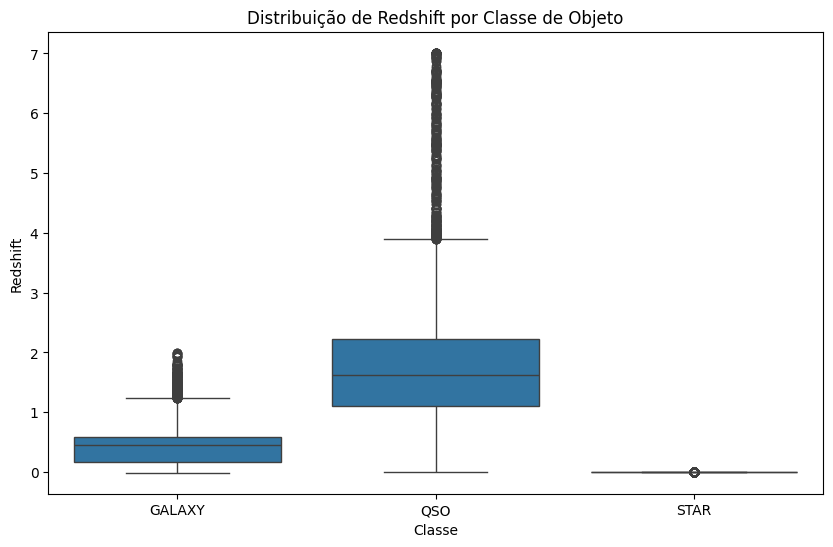

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

#Fazendo um boxplot por classe (estrela, galáxia e quasar)
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='redshift', data=df)
plt.title('Distribuição de Redshift por Classe de Objeto')
plt.xlabel('Classe')
plt.ylabel('Redshift')
plt.show()

#### Interpretação do Boxplot e Decisão de Filtragem

O boxplot acima revela uma diferença fundamental entre as classes:

- **Estrelas (STAR):** Apresentam `redshift` muito próximo de zero e com baixíssima variabilidade. Isso ocorre porque o redshift estelar é dominado pelo movimento próprio da estrela dentro da nossa galáxia, e não pela expansão do universo. Para o nosso objetivo de prever distâncias cosmológicas, esses dados não são apenas irrelevantes, mas também podem atrapalhar o modelo.
- **Galáxias (GALAXY) e Quasares (QSO):** Mostram uma distribuição de `redshift` muito mais ampla e com valores significativamente maiores, refletindo suas distâncias cosmológicas.

Com base nisso, tomamos a decisão de **remover a classe 'STAR'** do nosso dataset, focando a análise apenas em galáxias e quasares.

In [7]:
df_filtrado = df[df['class'] != 'STAR'].copy()
print(f"Número de objetos removidos (estrelas): {len(df) - len(df_filtrado)}")
df = df_filtrado

Número de objetos removidos (estrelas): 21594


### 5. Análise de Outliers no Redshift

Após remover as estrelas, o novo boxplot ainda mostra muitos pontos considerados outliers, especialmente para quasares. Antes de simplesmente removê-los, é crucial entender o que eles representam no contexto astronômico.

In [8]:
def identificar_outliers(df, coluna, classe):
    # Filtra o DataFrame pela classe
    df_classe = df[df['class'] == classe][coluna]

    # 1. Calcula os Quartis (Q1 e Q3)
    Q1 = df_classe.quantile(0.25)
    Q3 = df_classe.quantile(0.75)

    # 2. Calcula o Intervalo Interquartil (IQR)
    IQR = Q3 - Q1

    # 3. Calcula o Limite Superior (Outliers "altos")
    limite_superior = Q3 + 1.5 * IQR

    # Identifica os objetos que são outliers
    outliers = df[(df['class'] == classe) & (df[coluna] > limite_superior)]

    print(f"--- {classe} ---")
    print(f"Q1: {Q1:.4f} | Q3: {Q3:.4f} | IQR: {IQR:.4f}")
    print(f"Limite Superior (Outlier): {limite_superior:.4f}")
    print(f"Total de Outliers encontrados: {len(outliers)}")

    return outliers

# Analisa Outliers para GALAXY
outliers_galaxy = identificar_outliers(df, 'redshift', 'GALAXY')

# Analisa Outliers para QSO
outliers_qso = identificar_outliers(df, 'redshift', 'QSO')

--- GALAXY ---
Q1: 0.1645 | Q3: 0.5947 | IQR: 0.4302
Limite Superior (Outlier): 1.2400
Total de Outliers encontrados: 254
--- QSO ---
Q1: 1.1066 | Q3: 2.2203 | IQR: 1.1137
Limite Superior (Outlier): 3.8908
Total de Outliers encontrados: 362


Por mais que temos esses outliers, precisamos entender se eles de fato prejuicam o dataset ou se são coeretes. Sendo assim, o que seria um "valor alto" de redshift para cada tipo de objeto?

## Contexto do Redshift por Classe

Entender a distribuição do `redshift` por classe é vital para a modelagem, pois a magnitude do $z$ está diretamente ligada à **expansão do universo** e, consequentemente, à **distância** do objeto.

### 1. Galáxias (GALAXY)

O redshift das galáxias mais próximas é muito baixo (quase zero), mas aumenta significativamente com a distância, seguindo a Lei de Hubble.

* **Valores Típicos:** A maioria das galáxias observadas no SDSS tem redshift entre $z = 0.01$ e $z = 0.3$.
* **Galáxias Distantes:** Galáxias com $z > 0.4$ já são consideradas distantes.
* **Redshift Alto:** $z \ge 0.5$ é geralmente considerado um redshift alto, indicando que a galáxia está sendo observada quando o universo era significativamente mais jovem.
* **Limite Extremo:** Galáxias mais distantes já foram observadas com $z$ em torno de $z \approx 1$ a $z \approx 3$ (embora estas sejam raras e menos comuns no SDSS, a menos que sejam muito luminosas).

---

### 2. Quasares (QSO)

Os Quasares (Quasi-Stellar Objects) são os **Núcleos Ativos de Galáxias (AGN)** mais luminosos e energéticos conhecidos. Sua extrema luminosidade permite que sejam observados a distâncias muito maiores.

* **Valores Típicos:** Devido à sua luminosidade, a maioria dos Quasares no SDSS tem redshift entre **$z = 1.0$ e $z = 3.0$**.
* **$z > 4.0$:** Quasares com redshift acima de $z = 4.0$ são considerados **extremamente distantes** e pertencem a uma era muito jovem do universo.
* **Recordes: Os Quasares mais distantes já encontrados pela ciência têm $z$ acima de $z > 7$, com o recorde atual (em 2024) sendo de aproximadamente $z \approx 7.64$. Estes são os objetos mais antigos e distantes que se consegue detectar no universo primordial.

---


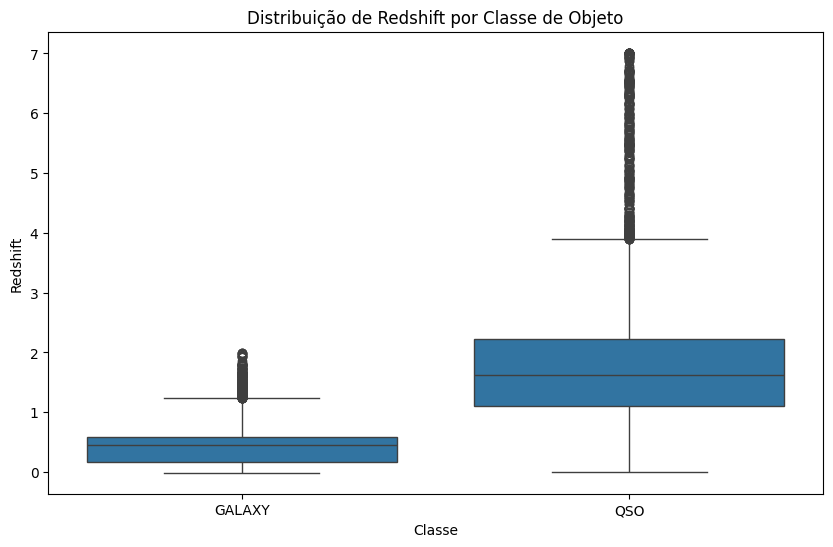

In [9]:
#Voltando para o boxplot, mas sem as estrelas

plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='redshift', data=df)
plt.title('Distribuição de Redshift por Classe de Objeto')
plt.xlabel('Classe')
plt.ylabel('Redshift')
plt.show()

Com base na análise física, concluímos que os "outliers" não são erros ou anomalias, mas sim **observações legítimas de objetos extremamente distantes**. Removê-los seria perder informações valiosas e limitar a capacidade do nosso modelo de prever altos valores de redshift. Portanto, eles serão mantidos.

In [10]:
#Encoding da feature class
df = pd.get_dummies(df, columns=['class'], drop_first=True)

### 6. Análise de Correlação

Agora que os dados estão limpos e filtrados, vamos investigar a relação entre as variáveis. Um mapa de calor é ideal para visualizar a matriz de correlação, mostrando a força e a direção da relação linear entre cada par de variáveis.

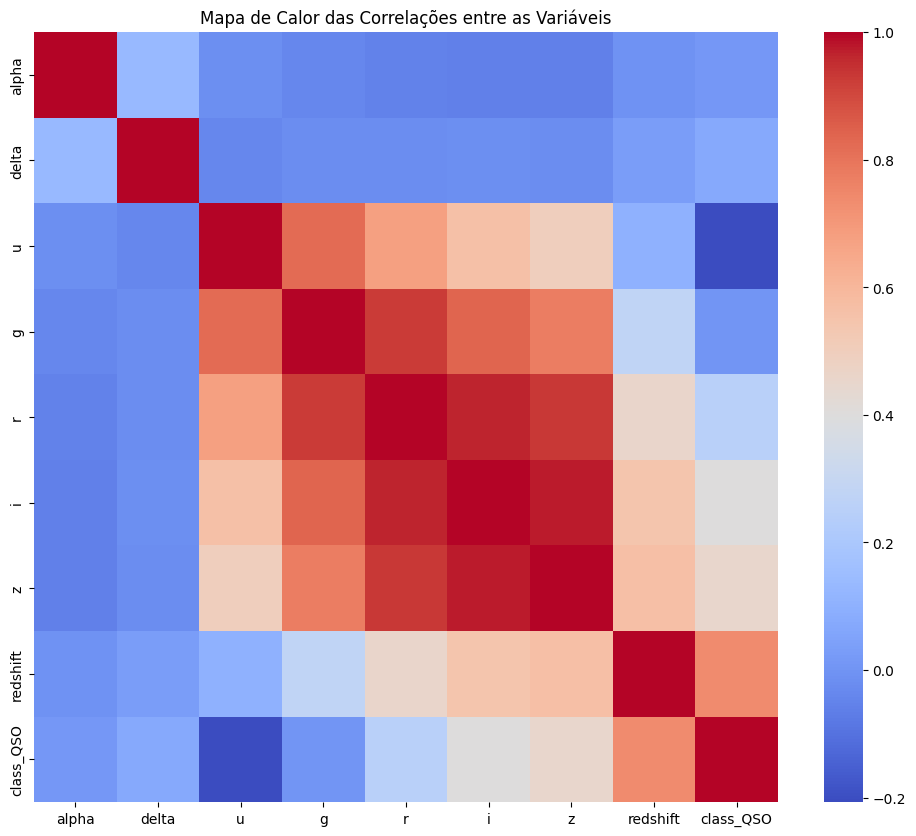

In [11]:
#Mapa das correlações
plt.figure(figsize=(12,10))
corr = df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Mapa de Calor das Correlações entre as Variáveis')
plt.show()

#### Interpretação do Mapa de Calor e Definição da Questão

O mapa de calor revela dois achados cruciais:

1.  **Alta Correlação entre Magnitudes:** Existe uma forte correlação positiva entre as magnitudes fotométricas (`u`, `g`, `r`, `i`, `z`). Isso é esperado, pois o brilho de um objeto em uma faixa de luz (filtro) tende a ser similar ao brilho em faixas adjacentes.
2.  **Relação com o Alvo (`redshift`):** As magnitudes (`u`, `g`, `r`, `i`, `z`) apresentam a **relação mais forte** (negativa) com a variável alvo, o `redshift`. Essa correlação negativa confirma um princípio astronômico fundamental: quanto maior o redshift (mais distante), mais fraco o objeto parece (maior o valor da magnitude, que é uma escala inversa).

Com base nesta forte evidência, a questão central do nosso modelo de regressão fica bem definida:

> **"É possível construir um modelo que utilize apenas as magnitudes fotométricas (`u`, `g`, `r`, `i`, `z`) para prever o valor contínuo do `redshift` de galáxias e quasares?"**

# PREPARAÇÃO DOS DADOS PARA O MODELO

### Remoção Final de Features

As colunas `alpha` e `delta` representam as coordenadas do objeto no céu. Embora úteis para localizar o objeto, elas não têm uma relação física direta com o `redshift` (um objeto pode estar em qualquer lugar do céu, independentemente de sua distância). Portanto, também as removeremos para focar o modelo apenas nas propriedades fotométricas.

In [12]:
colunas_a_descartar = ['alpha', 'delta',]

colunas_existentes = [col for col in colunas_a_descartar if col in df.columns]
if colunas_existentes:
    df = df.drop(columns=colunas_existentes)
    print(f"Colunas descartadas: {', '.join(colunas_existentes)}")

Colunas descartadas: alpha, delta


# SEPARAÇÃO DOS MODELOS DE TREINO E DE TESTE

In [13]:
X = df.drop('redshift', axis=1)
y = df['redshift']

# Divisão dos Dados em Conjuntos de Treino e Teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificação das dimensões dos conjuntos
print(f"\nDimensão do conjunto de treino: {X_train.shape}")
print(f"Dimensão do conjunto de teste: {X_test.shape}")


Dimensão do conjunto de treino: (62724, 6)
Dimensão do conjunto de teste: (15682, 6)


# NORMALIZAÇÃO DOS DADOS

In [14]:
from sklearn.preprocessing import StandardScaler

# Criação do objeto StandardScaler
scaler = StandardScaler()

# Ajuste do scaler apenas nos dados de treino
X_train_scaled = scaler.fit_transform(X_train)

# Aplicação da transformação nos dados de teste
X_test_scaled = scaler.transform(X_test)

# TREINANDO O MODELO

In [15]:
from sklearn.linear_model import LinearRegression

# Treinando o modelo de regressão linear
print("\nTreinando o modelo de Regressão Linear...")
model = LinearRegression()
model.fit(X_train_scaled, y_train)


Treinando o modelo de Regressão Linear...


LinearRegression()

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. Fazer as predições (usando os dados de teste)
y_pred = model.predict(X_test_scaled)

# 2. Calcular as métricas
# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
# R² (R-squared)
r2 = r2_score(y_test, y_pred)

print("\n--- Métricas de Avaliação do Modelo ---")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.4f}")
print(f"MAE (Erro Absoluto Médio): {mae:.4f}")


--- Métricas de Avaliação do Modelo ---
R² (Coeficiente de Determinação): 0.6337
RMSE (Raiz do Erro Quadrático Médio): 0.4533
MAE (Erro Absoluto Médio): 0.2327


## 📝 Conclusão e Interpretação dos Resultados

### Resposta à Questão Central

Nossa questão de pesquisa foi: **"É possível construir um modelo que utilize as magnitudes fotométricas (`u`, `g`, `r`, `i`, `z`) para prever o valor contínuo do `redshift` de galáxias e quasares?"**

Com base na análise e na avaliação do modelo de Regressão Linear, a resposta é **afirmativa**.

O modelo demonstrou um **poder preditivo significativo**, confirmando a forte relação entre as propriedades de cor de um objeto celeste (medidas pelas magnitudes) e sua distância cosmológica (redshift).

### Análise do Desempenho do Modelo

A avaliação do modelo no conjunto de teste forneceu as seguintes métricas:

| Métrica | Valor | Interpretação |
| :--- | :--- | :--- |
| **R² (Coeficiente de Determinação)** | **0.6337** (63.37%) | Indica que o modelo consegue explicar **63.37% da variabilidade** total do `redshift` dos objetos. Em problemas de astrofísica, onde os dados são inerentemente ruidosos, este é considerado um **bom ajuste**. |
| **MAE (Erro Absoluto Médio)** | **0.2327** | Em média, as previsões do nosso modelo erram o valor do `redshift` em aproximadamente $\Delta z = 0.23$. Este erro é relativamente pequeno, dado que o `redshift` máximo no nosso dataset filtrado se aproxima de $z=7.0$. |
| **RMSE (Raiz do Erro Quadrático Médio)** | **0.4533** | Por ser maior que o MAE, o RMSE indica que o modelo penaliza mais severamente alguns erros grandes. Isso se deve aos **outliers de alto redshift (Quasares)** que são mais difíceis de prever com precisão por um modelo linear simples. |

### Fundamentação e Implicações

1.  **Validação Física:** A **correlação negativa** observada na EDA (Mapa de Calor) foi a base para o sucesso do modelo. Objetos com **alto `redshift`** (distantes) possuem magnitudes **altas** (brilho fraco), e o modelo de Regressão Linear capturou e quantificou essa relação.
2.  **Importância dos Quasares:** A classe **'QSO'** (Quasares) mostrou-se como a *feature* de maior impacto no modelo (através da variável *dummy*). Isso valida nossa decisão de manter esses objetos, pois eles representam a extremidade da distribuição de `redshift` e são cruciais para o modelo aprender a relação entre cores e grandes distâncias.
3.  **Limitações:** O modelo de Regressão Linear é linear por natureza. Um $R^2$ de 0.6337 sugere que os $36.63\%$ restantes da variabilidade do `redshift` podem ser devidos a **relações não-lineares** ou variáveis que não foram incluídas. Para melhorar a precisão, futuras análises poderiam explorar modelos não-lineares (como Random Forest ou redes neurais) ou o uso de *features* mais complexas, como as cores calculadas ($\text{u-g}, \text{g-r}$, etc.).